# 🚀 Comprehensive Evaluation Framework for Wisent Guard

This notebook provides an interactive interface for running comprehensive evaluations that properly separate:

1. **🎯 Benchmark Performance**: How well the model solves mathematical problems
2. **🔍 Probe Performance**: How well probes detect correctness from model activations
3. **⚙️ Steering Optimization**: Grid search to find optimal steering configurations

## Key Features:
- **Interactive Configuration**: Easy parameter tuning with widgets
- **Real-time Progress**: Live updates during evaluation
- **Rich Visualizations**: Comprehensive plots and analysis
- **Modular Design**: Clean separation of concerns
- **Export Results**: Save results and generate reports

## 📋 Setup and Imports

In [ ]:
# Core imports
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Set HuggingFace cache to permanent directory
os.environ['HF_HOME'] = '/workspace/.cache/huggingface'
os.environ['TRANSFORMERS_CACHE'] = '/workspace/.cache/huggingface/transformers'
os.environ['HF_DATASETS_CACHE'] = '/workspace/.cache/huggingface/datasets'

# Create cache directories if they don't exist
os.makedirs('/workspace/.cache/huggingface/transformers', exist_ok=True)
os.makedirs('/workspace/.cache/huggingface/datasets', exist_ok=True)

# Add project root to path
project_root = '/workspace/wisent-guard'
if project_root not in sys.path:
    sys.path.append(project_root)

# Check HuggingFace authentication
def check_hf_auth():
    """Check if user is logged into HuggingFace and show login instructions if needed."""
    try:
        import subprocess
        result = subprocess.run(['huggingface-cli', 'whoami'], capture_output=True, text=True)
        if result.returncode == 0:
            username = result.stdout.strip()
            print(f"✅ Logged into HuggingFace as: {username}")
            return True
        else:
            print("⚠️ Not logged into HuggingFace!")
            print("🔐 Please run: huggingface-cli login")
            print("   This is required to access datasets like AIME 2024/2025")
            return False
    except Exception as e:
        print(f"⚠️ Could not check HuggingFace authentication: {e}")
        print("🔐 If you encounter dataset loading issues, try: huggingface-cli login")
        return False

# Import comprehensive evaluation framework
from wisent_guard.core.evaluation.comprehensive import (
    ComprehensiveEvaluationConfig,
    ComprehensiveEvaluationPipeline,
    plot_evaluation_results,
    create_results_dashboard,
    generate_summary_report,
    calculate_comprehensive_metrics,
    generate_performance_summary
)

# Visualization and interactivity
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from IPython.display import display, HTML, Markdown
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, fixed

# Data manipulation
import pandas as pd
import numpy as np
import json
from datetime import datetime
from pathlib import Path

# Utilities
from tqdm.notebook import tqdm
import logging

print("✅ All imports successful!")
print(f"📍 Working directory: {os.getcwd()}")
print(f"🐍 Python version: {sys.version}")
print(f"💾 HuggingFace cache: {os.environ['HF_HOME']}")
print()

# Check authentication
hf_authenticated = check_hf_auth()

## ⚙️ Interactive Configuration

Use the widgets below to configure your evaluation. The system will automatically set reasonable defaults based on your model choice.

In [ ]:
# Create interactive configuration widgets

# Import math tasks from our task configuration
import sys
sys.path.append('/workspace/wisent-guard')
from wisent_guard.parameters.task_config import MATH_TASKS

# Dataset size mapping - default 100 for math tasks with known exceptions
DATASET_SIZES = {
    'math500': 500,
    'aime': 30, 'aime2024': 30, 'aime2025': 30,
    'hmmt': 50, 'hmmt_feb_2025': 50,
    **{task: 100 for task in MATH_TASKS}
}

# Create simple dataset options from math tasks
math_options = [(task.replace('_', ' ').title(), task) for task in sorted(MATH_TASKS)]

# Model configuration
model_widget = widgets.Dropdown(
    options=[
        ('DistilGPT2 (Fast)', 'distilbert/distilgpt2'),
        ('GPT2', 'gpt2'),
        ('LLaMA 3.1 8B', '/workspace/models/llama31-8b-instruct-hf'),
        ('Qwen 3 8B', 'Qwen/Qwen3-8B')
    ],
    value='distilbert/distilgpt2',
    description='Model:'
)

# Dataset configuration
train_dataset_widget = widgets.Dropdown(options=math_options, value='math500', description='Train:')
val_dataset_widget = widgets.Dropdown(options=math_options, value='aime2024', description='Val:')
test_dataset_widget = widgets.Dropdown(options=math_options, value='aime2025', description='Test:')

# Sample limits with automatic adjustment
train_limit_widget = widgets.IntSlider(value=100, min=5, max=500, step=5, description='Train samples:')
val_limit_widget = widgets.IntSlider(value=30, min=3, max=100, step=2, description='Val samples:')
test_limit_widget = widgets.IntSlider(value=30, min=3, max=100, step=2, description='Test samples:')

# Simple update function
def update_limits():
    train_limit_widget.max = DATASET_SIZES.get(train_dataset_widget.value, 100)
    val_limit_widget.max = DATASET_SIZES.get(val_dataset_widget.value, 100)
    test_limit_widget.max = DATASET_SIZES.get(test_dataset_widget.value, 100)

# Set up observers
for widget in [train_dataset_widget, val_dataset_widget, test_dataset_widget]:
    widget.observe(lambda x: update_limits(), names='value')

update_limits()

# Advanced options
enable_wandb_widget = widgets.Checkbox(value=True, description='Enable W&B logging')
experiment_name_widget = widgets.Text(value='math_eval', description='Experiment:')

# Simple layout
display(widgets.VBox([
    widgets.HTML("<h3>🤖 Configuration</h3>"),
    model_widget,
    widgets.HTML("<h4>📊 Math Datasets</h4>"),
    widgets.HBox([train_dataset_widget, val_dataset_widget, test_dataset_widget]),
    widgets.HTML("<h4>🔢 Sample Limits</h4>"),
    widgets.HBox([train_limit_widget, val_limit_widget, test_limit_widget]),
    widgets.HTML("<h4>⚙️ Options</h4>"),
    widgets.HBox([enable_wandb_widget, experiment_name_widget])
]))

print(f"✅ {len(MATH_TASKS)} math datasets available | Default: 100 samples (auto-adjusted for smaller datasets)")
print("👆 Configure above, then run next cell")

## 🛠️ Create Configuration

Run this cell to create your evaluation configuration based on the widgets above.

In [3]:
# Create configuration from widget values
config = ComprehensiveEvaluationConfig(
    model_name=model_widget.value,
    train_dataset=train_dataset_widget.value,
    val_dataset=val_dataset_widget.value,
    test_dataset=test_dataset_widget.value,
    train_limit=train_limit_widget.value,
    val_limit=val_limit_widget.value,
    test_limit=test_limit_widget.value,
    enable_wandb=enable_wandb_widget.value,
    experiment_name=experiment_name_widget.value
)

# Display configuration summary
print("📋 CONFIGURATION SUMMARY")
print("="*50)
print(f"🤖 Model: {config.model_name}")
print(f"📊 Datasets: {config.train_dataset} → {config.val_dataset} → {config.test_dataset}")
print(f"🔢 Samples: {config.train_limit} + {config.val_limit} + {config.test_limit} = {config.train_limit + config.val_limit + config.test_limit} total")
print(f"🎯 Probe layers: {config.probe_layers}")
print(f"⚙️ Steering layers: {config.steering_layers}")
print(f"🧪 Total hyperparameter combinations: {config.get_hyperparameter_search_space_size()}")
print(f"📈 Wandb enabled: {config.enable_wandb}")
print("="*50)

# Estimate runtime
estimated_minutes = config.get_hyperparameter_search_space_size() * 0.5  # Rough estimate
print(f"⏱️ Estimated runtime: ~{estimated_minutes:.1f} minutes")

if config.get_hyperparameter_search_space_size() > 50:
    print("⚠️ Large search space detected. Consider reducing sample sizes for faster testing.")

print("\n✅ Configuration created successfully!")

📋 CONFIGURATION SUMMARY
🤖 Model: distilbert/distilgpt2
📊 Datasets: math500 → aime2024 → aime2025
🔢 Samples: 20 + 10 + 10 = 40 total
🎯 Probe layers: [2, 3, 4, 5]
⚙️ Steering layers: [3, 4, 5]
🧪 Total hyperparameter combinations: 36
📈 Wandb enabled: True
⏱️ Estimated runtime: ~18.0 minutes

✅ Configuration created successfully!


## 🚀 Run Comprehensive Evaluation

This is the main evaluation cell. It will:

1. **🎯 Train Probes**: Train correctness classifiers on all specified layers
2. **⚙️ Optimize Hyperparameters**: Grid search for best steering + probe combinations
3. **🏆 Final Evaluation**: Test optimized configuration on held-out test set

**Note**: This may take several minutes depending on your configuration.

In [4]:
# Initialize pipeline
pipeline = ComprehensiveEvaluationPipeline(config)

print("🚀 Starting comprehensive evaluation...")
print("This may take several minutes. Check the logs below for progress.")
print("\n" + "="*80)

# Run evaluation with progress tracking
try:
    results = pipeline.run_comprehensive_evaluation()
    print("\n" + "="*80)
    print("✅ Evaluation completed successfully!")
    
    # Store results for analysis
    evaluation_results = results
    
except Exception as e:
    print(f"\n❌ Evaluation failed: {str(e)}")
    print("Check the logs above for more details.")
    raise

wandb: Currently logged in as: janwisent (wisent) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


INFO:wisent_guard.core.evaluation.comprehensive.pipeline:Wandb experiment initialized successfully
INFO:wisent_guard.core.evaluation.comprehensive.pipeline:================================================================================
INFO:wisent_guard.core.evaluation.comprehensive.pipeline:🚀 STARTING COMPREHENSIVE EVALUATION PIPELINE
INFO:wisent_guard.core.evaluation.comprehensive.pipeline:================================================================================
INFO:wisent_guard.core.evaluation.comprehensive.pipeline:Train: math500
INFO:wisent_guard.core.evaluation.comprehensive.pipeline:Validation: aime2024
INFO:wisent_guard.core.evaluation.comprehensive.pipeline:Test: aime2025
INFO:wisent_guard.core.evaluation.comprehensive.pipeline:Model: distilbert/distilgpt2
INFO:wisent_guard.core.evaluation.comprehensive.data_utils:Loading model distilbert/distilgpt2 (ONCE)...


🚀 Starting comprehensive evaluation...
This may take several minutes. Check the logs below for progress.



INFO:wisent_guard.core.evaluation.comprehensive.data_utils:✓ Model loaded on cuda, GPU memory: 0.16 GB
INFO:wisent_guard.core.evaluation.comprehensive.pipeline:
📊 Loading datasets...
INFO:wisent_guard.core.evaluation.comprehensive.data_utils:Loading 20 samples from math500...
INFO:wisent_guard.core.evaluation.comprehensive.data_utils:Loaded 20 samples from math500 via Math500Task
INFO:wisent_guard.core.evaluation.comprehensive.data_utils:Loading 10 samples from aime2024...
INFO:wisent_guard.core.evaluation.comprehensive.data_utils:Loaded 10 samples from aime2024 via AIMETask
INFO:wisent_guard.core.evaluation.comprehensive.data_utils:Loading 10 samples from aime2025...
INFO:wisent_guard.core.evaluation.comprehensive.data_utils:Loaded 10 samples from aime2025 via AIMETask
INFO:wisent_guard.core.evaluation.comprehensive.pipeline:
🎯 Phase 1: Training Probes...
INFO:wisent_guard.core.evaluation.comprehensive.pipeline:Training probes for layer 2...
INFO:wisent_guard.core.evaluation.comprehen

timestamp,2025-07-24T13:42:34....



✅ Evaluation completed successfully!


## 📊 Results Analysis

Now let's analyze the results with comprehensive metrics and visualizations.

In [5]:
# Calculate comprehensive metrics
comprehensive_metrics = calculate_comprehensive_metrics(evaluation_results)

# Generate performance summary
performance_summary = generate_performance_summary(comprehensive_metrics)
print(performance_summary)

COMPREHENSIVE EVALUATION PERFORMANCE SUMMARY

📊 BENCHMARK PERFORMANCE:
  Base Model Accuracy:    0.000 (0.0%)
  Steered Model Accuracy: 0.000 (0.0%)
  Improvement:            +0.000 (+0.0%)

🔍 PROBE PERFORMANCE:
  Base Model Probe AUC:    0.775
  Steered Model Probe AUC: 0.775
  Improvement:             +0.000

🎯 TRAINING STATISTICS:
  Probe Training AUC:      0.939 ± 0.000
  Best Training AUC:       0.939

⚙️ OPTIMIZATION STATISTICS:
  Configurations Tested:   3
  Best Validation Score:   0.281

🏆 OVERALL ASSESSMENT:
  Steering Effectiveness:  Minimal Effect (+0.000)


## 📈 Interactive Visualizations

Explore your results with interactive plots.

In [6]:
# Create interactive dashboard
dashboard = create_results_dashboard(evaluation_results)
dashboard.show()

print("\n📊 Interactive dashboard displayed above!")
print("💡 Hover over points and bars for detailed information.")


📊 Interactive dashboard displayed above!
💡 Hover over points and bars for detailed information.


## 🎯 Detailed Analysis: Benchmark Performance

In [7]:
# Extract benchmark results
if "test_results" in evaluation_results:
    test_results = evaluation_results["test_results"]
    
    base_benchmark = test_results.get("base_model_benchmark_results", {})
    steered_benchmark = test_results.get("steered_model_benchmark_results", {})
    
    print("🎯 BENCHMARK PERFORMANCE ANALYSIS")
    print("="*40)
    
    print(f"\n📊 Base Model:")
    print(f"  ✓ Accuracy: {base_benchmark.get('accuracy', 0):.3f} ({base_benchmark.get('accuracy', 0)*100:.1f}%)")
    print(f"  ✓ Correct: {base_benchmark.get('correct', 0)}/{base_benchmark.get('total_samples', 0)}")
    
    print(f"\n🎯 Steered Model:")
    print(f"  ✓ Accuracy: {steered_benchmark.get('accuracy', 0):.3f} ({steered_benchmark.get('accuracy', 0)*100:.1f}%)")
    print(f"  ✓ Correct: {steered_benchmark.get('correct', 0)}/{steered_benchmark.get('total_samples', 0)}")
    
    improvement = steered_benchmark.get('accuracy', 0) - base_benchmark.get('accuracy', 0)
    improvement_percent = (improvement / max(base_benchmark.get('accuracy', 0.001), 0.001)) * 100
    
    print(f"\n📈 Improvement:")
    print(f"  {'✅' if improvement > 0 else '❌'} {improvement:+.3f} absolute ({improvement_percent:+.1f}% relative)")
    
    if improvement > 0.05:
        print("  🎉 Significant improvement! Steering is working well.")
    elif improvement > 0.01:
        print("  👍 Moderate improvement. Consider tuning hyperparameters.")
    elif improvement > -0.01:
        print("  ⚪ Minimal change. Steering may not be effective for this configuration.")
    else:
        print("  ⚠️ Performance decreased. Check steering implementation.")
else:
    print("❌ No test results found in evaluation data.")

🎯 BENCHMARK PERFORMANCE ANALYSIS

📊 Base Model:
  ✓ Accuracy: 0.000 (0.0%)
  ✓ Correct: 0/10

🎯 Steered Model:
  ✓ Accuracy: 0.000 (0.0%)
  ✓ Correct: 0/10

📈 Improvement:
  ❌ +0.000 absolute (+0.0% relative)
  ⚪ Minimal change. Steering may not be effective for this configuration.


## 🔍 Detailed Analysis: Probe Performance

In [8]:
# Extract probe results
if "test_results" in evaluation_results:
    base_probe = test_results.get("base_model_probe_results", {})
    steered_probe = test_results.get("steered_model_probe_results", {})
    
    print("🔍 PROBE PERFORMANCE ANALYSIS")
    print("="*40)
    
    print(f"\n📊 Base Model Probe:")
    print(f"  ✓ AUC: {base_probe.get('auc', 0.5):.3f}")
    print(f"  ✓ Accuracy: {base_probe.get('accuracy', 0.5):.3f}")
    print(f"  ✓ Precision: {base_probe.get('precision', 0.5):.3f}")
    print(f"  ✓ Recall: {base_probe.get('recall', 0.5):.3f}")
    print(f"  ✓ F1-Score: {base_probe.get('f1', 0.5):.3f}")
    
    print(f"\n🎯 Steered Model Probe:")
    print(f"  ✓ AUC: {steered_probe.get('auc', 0.5):.3f}")
    print(f"  ✓ Accuracy: {steered_probe.get('accuracy', 0.5):.3f}")
    print(f"  ✓ Precision: {steered_probe.get('precision', 0.5):.3f}")
    print(f"  ✓ Recall: {steered_probe.get('recall', 0.5):.3f}")
    print(f"  ✓ F1-Score: {steered_probe.get('f1', 0.5):.3f}")
    
    auc_improvement = steered_probe.get('auc', 0.5) - base_probe.get('auc', 0.5)
    
    print(f"\n📈 AUC Improvement:")
    print(f"  {'✅' if auc_improvement > 0 else '❌'} {auc_improvement:+.3f}")
    
    # Interpret probe performance
    best_auc = max(base_probe.get('auc', 0.5), steered_probe.get('auc', 0.5))
    
    if best_auc > 0.9:
        print("  🎉 Excellent probe performance! Activations strongly predict correctness.")
    elif best_auc > 0.8:
        print("  👍 Good probe performance. Activations are informative.")
    elif best_auc > 0.7:
        print("  ⚪ Moderate probe performance. Some signal present.")
    elif best_auc > 0.6:
        print("  ⚠️ Weak probe performance. Limited interpretability.")
    else:
        print("  ❌ Poor probe performance. Activations may not encode correctness.")
else:
    print("❌ No test results found in evaluation data.")

🔍 PROBE PERFORMANCE ANALYSIS

📊 Base Model Probe:
  ✓ AUC: 0.775
  ✓ Accuracy: 0.750
  ✓ Precision: 0.778
  ✓ Recall: 0.700
  ✓ F1-Score: 0.737

🎯 Steered Model Probe:
  ✓ AUC: 0.775
  ✓ Accuracy: 0.750
  ✓ Precision: 0.778
  ✓ Recall: 0.700
  ✓ F1-Score: 0.737

📈 AUC Improvement:
  ❌ +0.000
  ⚪ Moderate probe performance. Some signal present.


## ⚙️ Hyperparameter Optimization Analysis

In [9]:
# Analyze hyperparameter optimization results
if "steering_optimization_results" in evaluation_results:
    opt_results = evaluation_results["steering_optimization_results"]
    all_configs = opt_results.get("all_configs", [])
    best_config = opt_results.get("best_config", {})
    
    print("⚙️ HYPERPARAMETER OPTIMIZATION ANALYSIS")
    print("="*45)
    
    print(f"\n📊 Search Statistics:")
    print(f"  ✓ Configurations tested: {len(all_configs)}")
    print(f"  ✓ Best combined score: {opt_results.get('best_combined_score', 0):.3f}")
    
    if best_config:
        steering_config = best_config.get("steering_config", {})
        probe_config = best_config.get("best_probe_config", {})
        
        print(f"\n🏆 Best Configuration:")
        print(f"  ✓ Steering method: {steering_config.get('method', 'N/A')}")
        print(f"  ✓ Steering layer: {steering_config.get('layer', 'N/A')}")
        print(f"  ✓ Steering strength: {steering_config.get('strength', 'N/A')}")
        print(f"  ✓ Probe layer: {probe_config.get('layer', 'N/A')}")
        print(f"  ✓ Probe C value: {probe_config.get('C', 'N/A')}")
        
        benchmark_metrics = best_config.get("benchmark_metrics", {})
        probe_metrics = best_config.get("probe_metrics", {})
        
        print(f"\n📈 Best Configuration Performance:")
        print(f"  ✓ Benchmark accuracy: {benchmark_metrics.get('accuracy', 0):.3f}")
        print(f"  ✓ Probe AUC: {probe_metrics.get('auc', 0.5):.3f}")
        print(f"  ✓ Combined score: {best_config.get('combined_score', 0):.3f}")
    
    # Analyze score distribution
    if all_configs:
        scores = [config.get("combined_score", 0) for config in all_configs]
        benchmark_scores = [config.get("benchmark_metrics", {}).get("accuracy", 0) for config in all_configs]
        probe_scores = [config.get("probe_metrics", {}).get("auc", 0.5) for config in all_configs]
        
        print(f"\n📊 Score Distribution:")
        print(f"  ✓ Combined score: {np.mean(scores):.3f} ± {np.std(scores):.3f}")
        print(f"  ✓ Benchmark score: {np.mean(benchmark_scores):.3f} ± {np.std(benchmark_scores):.3f}")
        print(f"  ✓ Probe score: {np.mean(probe_scores):.3f} ± {np.std(probe_scores):.3f}")
        
        # Check if optimization was effective
        score_range = max(scores) - min(scores)
        if score_range > 0.1:
            print("  🎯 Good optimization! Significant variation in scores.")
        elif score_range > 0.05:
            print("  👍 Moderate optimization. Some configurations better than others.")
        else:
            print("  ⚪ Limited optimization benefit. Most configurations perform similarly.")
else:
    print("❌ No optimization results found in evaluation data.")

⚙️ HYPERPARAMETER OPTIMIZATION ANALYSIS

📊 Search Statistics:
  ✓ Configurations tested: 3
  ✓ Best combined score: 0.281

🏆 Best Configuration:
  ✓ Steering method: baseline
  ✓ Steering layer: 3
  ✓ Steering strength: 1.0
  ✓ Probe layer: 2
  ✓ Probe C value: 10.0

📈 Best Configuration Performance:
  ✓ Benchmark accuracy: 0.000
  ✓ Probe AUC: 0.935
  ✓ Combined score: 0.281

📊 Score Distribution:
  ✓ Combined score: 0.281 ± 0.000
  ✓ Benchmark score: 0.000 ± 0.000
  ✓ Probe score: 0.935 ± 0.000
  ⚪ Limited optimization benefit. Most configurations perform similarly.


## 📊 Training Performance Analysis

In [10]:
# Analyze probe training performance by layer
if "probe_training_results" in evaluation_results:
    training_results = evaluation_results["probe_training_results"]
    
    print("📊 PROBE TRAINING ANALYSIS")
    print("="*35)
    
    # Create summary table
    training_data = []
    
    for layer_key, layer_results in training_results.items():
        layer_num = int(layer_key.split('_')[1])
        
        best_auc = 0
        best_config = None
        
        for c_key, metrics in layer_results.items():
            if isinstance(metrics, dict) and "auc" in metrics:
                if metrics["auc"] > best_auc:
                    best_auc = metrics["auc"]
                    best_config = c_key
        
        training_data.append({
            'Layer': layer_num,
            'Best AUC': best_auc,
            'Best C': best_config.replace('C_', '') if best_config else 'N/A'
        })
    
    # Display as formatted table
    df_training = pd.DataFrame(training_data).sort_values('Layer')
    
    print(f"\n{'Layer':<8} {'Best AUC':<10} {'Best C':<10}")
    print("-" * 30)
    
    for _, row in df_training.iterrows():
        print(f"{row['Layer']:<8} {row['Best AUC']:<10.3f} {row['Best C']:<10}")
    
    # Find best performing layer
    best_layer_row = df_training.loc[df_training['Best AUC'].idxmax()]
    worst_layer_row = df_training.loc[df_training['Best AUC'].idxmin()]
    
    print(f"\n🏆 Best performing layer: {best_layer_row['Layer']} (AUC: {best_layer_row['Best AUC']:.3f})")
    print(f"⚠️ Worst performing layer: {worst_layer_row['Layer']} (AUC: {worst_layer_row['Best AUC']:.3f})")
    
    # Layer performance insights
    auc_std = df_training['Best AUC'].std()
    if auc_std > 0.1:
        print("\n💡 High variation across layers - layer choice matters!")
    elif auc_std > 0.05:
        print("\n💡 Moderate variation - some layers work better than others.")
    else:
        print("\n💡 Consistent performance across layers.")
        
else:
    print("❌ No training results found in evaluation data.")

📊 PROBE TRAINING ANALYSIS

Layer    Best AUC   Best C    
------------------------------
2        0.939      0.1       
3        0.939      0.1       
4        0.939      0.1       
5        0.939      0.1       

🏆 Best performing layer: 2 (AUC: 0.939)
⚠️ Worst performing layer: 2 (AUC: 0.939)

💡 Consistent performance across layers.


## 📈 Static Visualizations

Create comprehensive static plots for reports and publications.

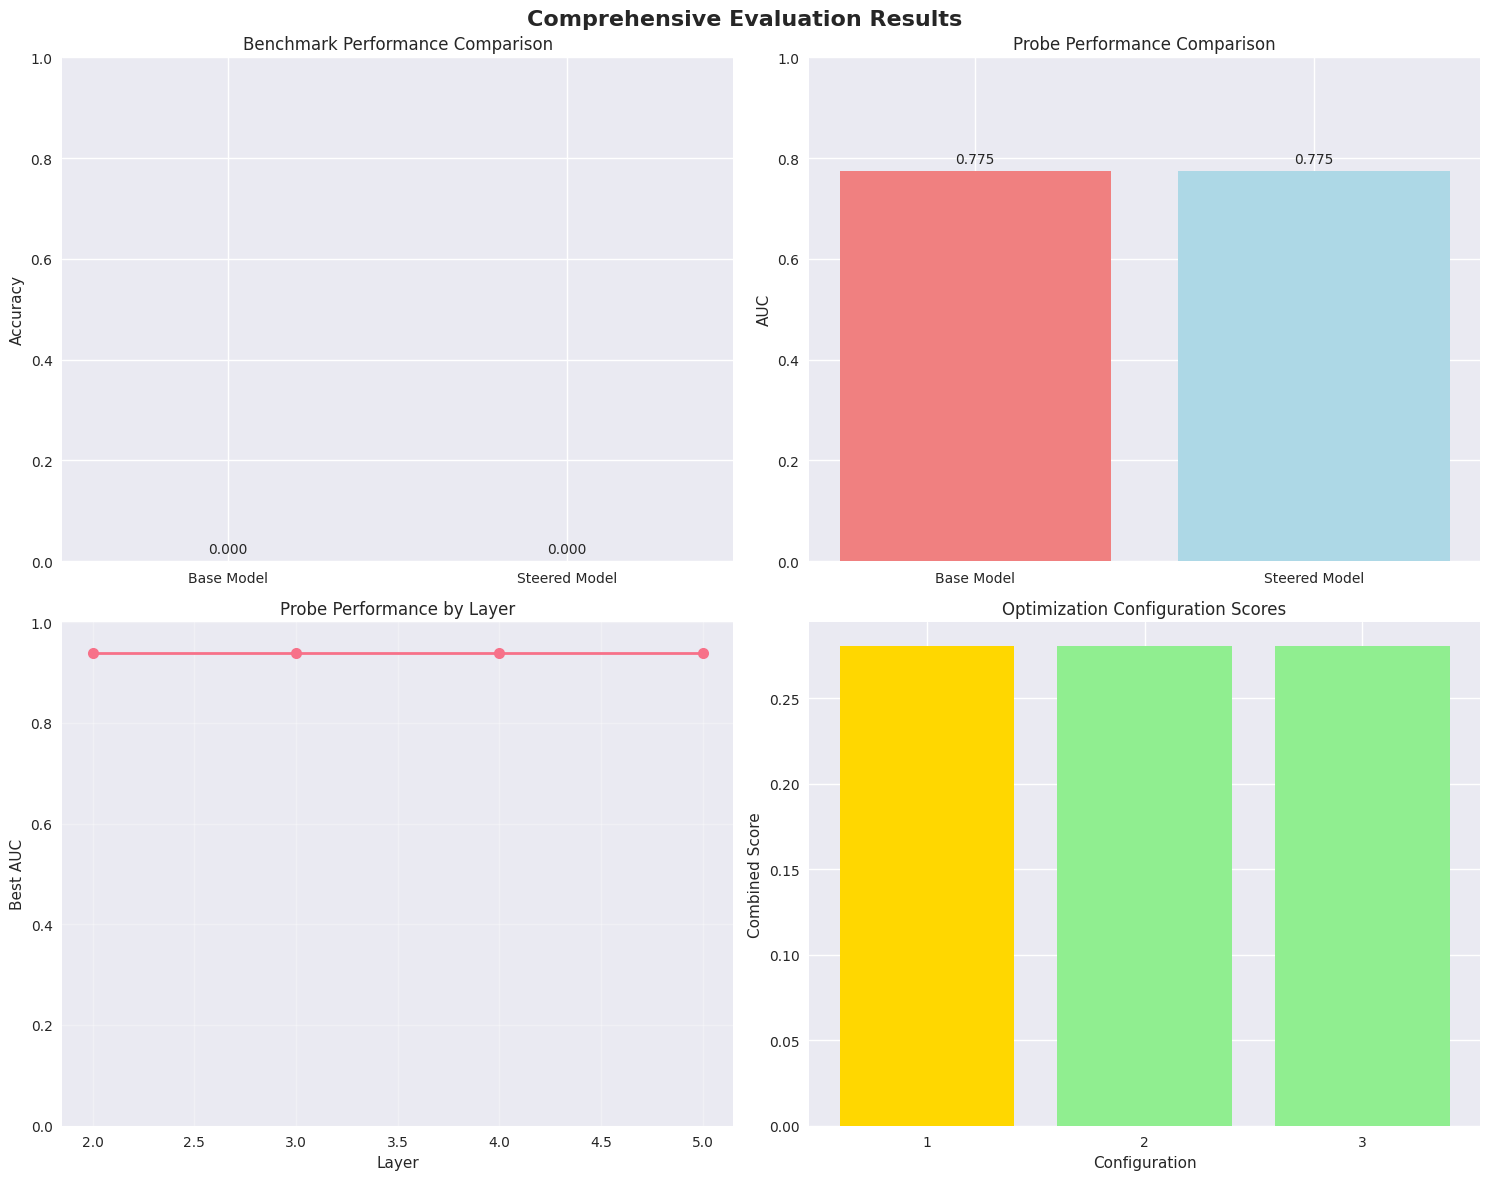

📊 Comprehensive evaluation plots displayed above.
💾 Plots are saved automatically in the results directory.


In [11]:
# Create comprehensive static visualization
fig = plot_evaluation_results(evaluation_results)
plt.show()

print("📊 Comprehensive evaluation plots displayed above.")
print("💾 Plots are saved automatically in the results directory.")

## 💾 Export Results

Save your results in various formats for further analysis.

In [ ]:
# Results Export and Storage Options
print("📊 RESULTS STORAGE SUMMARY")
print("="*50)

# Check if wandb is enabled and results were logged
if config.enable_wandb:
    print("✅ Weights & Biases logging is ENABLED")
    print("📈 All evaluation results have been automatically logged to wandb including:")
    print("   • Configuration parameters")
    print("   • Probe training metrics")
    print("   • Hyperparameter optimization results") 
    print("   • Final test performance")
    print("   • Comprehensive metrics and visualizations")
    print()
    print("🔗 Access your results on the wandb dashboard:")
    print("   https://wandb.ai/")
else:
    print("⚠️ Weights & Biases logging is DISABLED")
    print("💾 Creating local backup files...")
    
    # Create results directory in outputs/ (excluded from git)
    results_dir = Path("outputs/notebook_results")
    results_dir.mkdir(parents=True, exist_ok=True)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # 1. Save raw results as JSON
    json_file = results_dir / f"evaluation_results_{timestamp}.json"
    with open(json_file, 'w') as f:
        # Remove non-serializable objects
        import copy
        results_copy = copy.deepcopy(evaluation_results)
        
        def remove_non_serializable(obj):
            if isinstance(obj, dict):
                return {k: remove_non_serializable(v) for k, v in obj.items() if k != 'probe'}
            elif isinstance(obj, list):
                return [remove_non_serializable(item) for item in obj]
            else:
                return obj
        
        clean_results = remove_non_serializable(results_copy)
        json.dump(clean_results, f, indent=2, default=str)
    
    print(f"✅ Raw results saved to: {json_file}")
    
    # 2. Save comprehensive metrics as CSV
    csv_file = results_dir / f"comprehensive_metrics_{timestamp}.csv"
    metrics_df = pd.DataFrame([comprehensive_metrics])
    metrics_df.to_csv(csv_file, index=False)
    
    print(f"✅ Comprehensive metrics saved to: {csv_file}")
    
    # 3. Generate HTML report
    html_report = generate_summary_report(evaluation_results, config.to_dict())
    html_file = results_dir / f"evaluation_report_{timestamp}.html"
    with open(html_file, 'w') as f:
        f.write(html_report)
    
    print(f"✅ HTML report saved to: {html_file}")
    
    # 4. Save configuration
    config_file = results_dir / f"configuration_{timestamp}.json"
    with open(config_file, 'w') as f:
        json.dump(config.to_dict(), f, indent=2)
    
    print(f"✅ Configuration saved to: {config_file}")
    
    print(f"\n📁 All results saved in: {results_dir.absolute()}")

print("\n💡 Recommendation:")
if config.enable_wandb:
    print("   Use wandb dashboard for comprehensive result analysis and comparison.")
    print("   Results are automatically versioned and shareable via wandb.")
else:
    print("   Enable wandb logging for better experiment tracking and result management.")
    print("   Set enable_wandb=True in the configuration for future runs.")

print("\n🎉 Evaluation complete!")

## 🔍 Optional: Detailed Data Exploration

Use this section to explore specific aspects of your results.

In [ ]:
# Interactive data exploration
@interact
def explore_results(
    section=widgets.Dropdown(
        options=['Configuration', 'Training Results', 'Optimization Results', 'Test Results'],
        value='Configuration'
    )
):
    if section == 'Configuration':
        display(Markdown("### 📋 Configuration Details"))
        # Fix UnboundLocalError by accessing config from global scope
        if 'config' in globals():
            config_df = pd.DataFrame(list(config.to_dict().items()), columns=['Parameter', 'Value'])
            display(config_df)
        else:
            print("⚠️ Configuration not available. Please run the configuration cell first.")
        
    elif section == 'Training Results':
        display(Markdown("### 🎯 Probe Training Results"))
        if "probe_training_results" in evaluation_results:
            training_data = []
            for layer_key, layer_results in evaluation_results["probe_training_results"].items():
                layer_num = int(layer_key.split('_')[1])
                for c_key, metrics in layer_results.items():
                    if isinstance(metrics, dict) and "auc" in metrics:
                        training_data.append({
                            'Layer': layer_num,
                            'C': float(c_key.replace('C_', '')),
                            'Accuracy': metrics.get('accuracy', 0),
                            'AUC': metrics.get('auc', 0.5),
                            'Precision': metrics.get('precision', 0),
                            'Recall': metrics.get('recall', 0),
                            'F1': metrics.get('f1', 0)
                        })
            if training_data:
                training_df = pd.DataFrame(training_data)
                display(training_df.round(3))
        else:
            print("No training results available.")
            
    elif section == 'Optimization Results':
        display(Markdown("### ⚙️ Hyperparameter Optimization Results"))
        if "steering_optimization_results" in evaluation_results:
            opt_results = evaluation_results["steering_optimization_results"]
            all_configs = opt_results.get("all_configs", [])
            
            if all_configs:
                opt_data = []
                for i, config_item in enumerate(all_configs):
                    steering_config = config_item.get("steering_config", {})
                    probe_config = config_item.get("best_probe_config", {})
                    
                    opt_data.append({
                        'Config': i + 1,
                        'Steering Method': steering_config.get('method', 'N/A'),
                        'Steering Layer': steering_config.get('layer', 'N/A'),
                        'Steering Strength': steering_config.get('strength', 'N/A'),
                        'Probe Layer': probe_config.get('layer', 'N/A'),
                        'Probe C': probe_config.get('C', 'N/A'),
                        'Benchmark Accuracy': config_item.get('benchmark_metrics', {}).get('accuracy', 0),
                        'Probe AUC': config_item.get('probe_metrics', {}).get('auc', 0.5),
                        'Combined Score': config_item.get('combined_score', 0)
                    })
                
                opt_df = pd.DataFrame(opt_data)
                display(opt_df.round(3))
        else:
            print("No optimization results available.")
            
    elif section == 'Test Results':
        display(Markdown("### 🏆 Final Test Results"))
        if "test_results" in evaluation_results:
            test_results = evaluation_results["test_results"]
            
            # Create summary table
            summary_data = {
                'Metric': [
                    'Base Benchmark Accuracy',
                    'Steered Benchmark Accuracy', 
                    'Base Probe AUC',
                    'Steered Probe AUC',
                    'Validation Combined Score'
                ],
                'Value': [
                    test_results.get('base_model_benchmark_results', {}).get('accuracy', 0),
                    test_results.get('steered_model_benchmark_results', {}).get('accuracy', 0),
                    test_results.get('base_model_probe_results', {}).get('auc', 0.5),
                    test_results.get('steered_model_probe_results', {}).get('auc', 0.5),
                    test_results.get('validation_combined_score', 0)
                ]
            }
            
            summary_df = pd.DataFrame(summary_data)
            display(summary_df.round(3))
        else:
            print("No test results available.")

print("🔍 Use the dropdown above to explore different sections of your results.")

## 🎉 Conclusion

Congratulations! You've successfully run a comprehensive evaluation that separates:

1. **🎯 Benchmark Performance**: How well your model solves problems
2. **🔍 Probe Performance**: How well we can detect when the model is wrong
3. **⚙️ Optimization**: Finding the best configurations through proper validation

### Next Steps:
- 📊 Analyze the results above to understand your model's behavior
- 🔧 Try different configurations to see how they affect performance
- 📈 Use the exported results for further analysis or reporting
- 🚀 Scale up to larger models and datasets when ready

### Key Insights:
- The framework properly separates model capability from interpretability
- Hyperparameter optimization validates on actual performance, not just probe metrics
- Results are saved and visualized for easy interpretation

Happy experimenting! 🧪✨